#### Detección de intrusión

Preprocesamiento de datos:
Todas las características se convierten en numéricas utilizando one-Hot-encoding. Las características se escalan para evitar características con valores grandes que puedan pesar demasiado en los resultados.

Selección de características:
Se podría utilizar la prueba de análisis de varianza (ANOVA) para seleccionar las características univariante. Esta prueba analiza cada característica individualmente para determinar la fuerza de cada caracteristica en el conjunto de datos. 
Analizar el método SecondPercentile (sklearn.feature_selection) para seleccionar características basadas en el percentil de las puntuaciones más altas.

In [ ]:
def search ( start , stop ):
  ''': param start : estado inicial
  : param stop : test objetivo
  trajectory () nos devuelve el recorrido al nodo'''
  # deque(): añade y elimina elementos desde cualquier extremo, en una cola de doble extremo 
  frontera = deque()
  # El método set() convierte cualquier iterable en una secuencia de elementos iterables con elementos distintos. 
  explored = set()
  if( stop( start ) ):
    return trajectory( start )
  frontera.append( start )
  while ( frontera ):
    nodo = frontera.popleft()
    explored.add ( nodo )
    for child in nodo.expand():
      if stop ( child ) :
        return trajectory( child )
      elif not child in explored:
        frontera.append(child)
  return None

## Importar módulos de Python

In [ ]:
import pandas as pd
import numpy as np
import sys
import sklearn
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

1.1.5
1.19.5
3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
0.22.2.post1


In [ ]:
pip install treeinterpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti

## Cargar datos

In [ ]:
# Adjuntar los nombres de las columnas al conjunto de datos
nom_col = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# KDDTrain.csv y KDDTest.csv son los archivos de datos.
df = pd.read_csv("KDDTrain.csv", header=None, names = nom_col)
df_test = pd.read_csv("KDDTest.csv", header=None, names = nom_col)

# shape: brinda las dimensiones del conjunto de datos
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


## Muestra del conjunto de datos de entrenamiento

In [ ]:
# cinco primeras filas
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


## Resumen estadístico

In [ ]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Distribución de datos en el conjunto de entrenamiento y en el de prueba

In [ ]:
print('Distribución en el conjunto de entrenamiento:')
print(df['label'].value_counts())
print('\nDistribución en el conjunto de prueba:')
print(df_test['label'].value_counts())

Distribución en el conjunto de entrenamiento:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Distribución en el conjunto de prueba:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
s

# Preprocesamiento de datos:

One-Hot-Encoding (one-of-K) se utiliza para transformar todas las características categóricas (las que no son numéricas) en características binarias. Requisito para la codificación: "La entrada de este transformador debe ser una matriz de enteros, que denote los valores que toman las características categóricas (discretas). La salida será una matriz dispersa en la que cada columna corresponde a un valor posible de una característica. Se supone que las características de entrada toman valores en el rango [0, n_valores)".

Por lo tanto, primero hay que transformar las características con LabelEncoder, para transformar cada categoría en un número.

## Identificar las características categóricas

In [ ]:
# Columnas que son categóricas: protocol_type (columna 2), service (columna 3), flag (columna 4).
# Explorar las características categóricas
print('Conjunto de entrenamiento:')
for nom_col in df.columns:
    if df[nom_col].dtypes == 'object' :
        unique_cat = len(df[nom_col].unique())
        print("La característica '{nom_col}' tiene {unique_cat} categorías".format(nom_col=nom_col, unique_cat=unique_cat))

# Distribución de la columna servicio (service), se distribuye uniformemente y por lo tanto tenemos que hacer dummies para todos.
print('\nDistribución de las categorías en la característica servicio (service):')
print(df['service'].value_counts().sort_values(ascending=False).head())

Conjunto de entrenamiento:
La característica 'protocol_type' tiene 3 categorías
La característica 'service' tiene 70 categorías
La característica 'flag' tiene 11 categorías
La característica 'label' tiene 23 categorías

Distribución de las categorías en la característica servicio (service):
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [ ]:
# Conjunto de prueba
print('Conjunto de prueba:')
for nom_col in df_test.columns:
    if df_test[nom_col].dtypes == 'object' :
        unique_cat = len(df_test[nom_col].unique())
        print("La caracterítica '{nom_col}' tiene {unique_cat} categorías".format(nom_col=nom_col, unique_cat=unique_cat))

# Distribución de la columna servicio (service), se distribuye uniformemente y por lo tanto tenemos que hacer dummies para todos.
print('\nDistribución de las categorías en la característica servicio (service):')
print(df_test['service'].value_counts().sort_values(ascending=False).head())

Conjunto de prueba:
La caracterítica 'protocol_type' tiene 3 categorías
La caracterítica 'service' tiene 64 categorías
La caracterítica 'flag' tiene 11 categorías
La caracterítica 'label' tiene 38 categorías

Distribución de las categorías en la característica servicio (service):
http       7853
private    4774
telnet     1626
pop_3      1019
smtp        934
Name: service, dtype: int64


### Observación: Es necesario hacer dummies para todas las categorías ya que la distribución es bastante uniforme. En total: 3+70+11=84 dummies.
### La comparación de los resultados muestra que el conjunto de prueba tiene menos categorías (6), que deben añadirse como columnas vacías.

# LabelEncoder

### Insertar características categóricas en un array numpy 2D

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#categorical_columns=['protocol_type', 'service', 'flag']
# insertar código para obtener una lista de columnas categóricas en una variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag'] 
 # Obtener los valores categóricos en un array numpy 2D
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


### nombres de columnas para dummies

In [ ]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# Armado
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

# hacer lo mismo para el conjunto de prueba
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

## Transformar las características categóricas en números mediante LabelEncoder()

In [ ]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head())
# Datos de prueba
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


# One-Hot-Encoding

In [ ]:
enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# Conjunto de prueba
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Añadir 6 categorías que faltan del conjunto de entrenamiento al conjunto de prueba

In [ ]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_http_2784',
 'service_red_i',
 'service_aol',
 'service_urh_i',
 'service_http_8001',
 'service_harvest']

In [ ]:
for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

(22544, 84)

## Unir el dataframe de datos categóricos codificados con el dataframe de datos no categóricos

In [ ]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# Conjunto de datos de prueba
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)


(125973, 123)
(22544, 123)


In [ ]:
print(newdf.describe)

<bound method NDFrame.describe of         duration  src_bytes  dst_bytes  ...  flag_S3  flag_SF  flag_SH
0              0        491          0  ...      0.0      1.0      0.0
1              0        146          0  ...      0.0      1.0      0.0
2              0          0          0  ...      0.0      0.0      0.0
3              0        232       8153  ...      0.0      1.0      0.0
4              0        199        420  ...      0.0      1.0      0.0
...          ...        ...        ...  ...      ...      ...      ...
125968         0          0          0  ...      0.0      0.0      0.0
125969         8        105        145  ...      0.0      1.0      0.0
125970         0       2231        384  ...      0.0      1.0      0.0
125971         0          0          0  ...      0.0      0.0      0.0
125972         0        151          0  ...      0.0      1.0      0.0

[125973 rows x 123 columns]>


In [ ]:
newdf.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,Protocol_type_icmp,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Dividir el conjunto de datos en 4 grupo, uno para cada categoría de ataque

Los ataques se dividen en cuatro categorías principales:

*   **DOS**: Denial Of Service - Ataques de Denegación de Servicios;
*   **R2L**: Remote to Local - Ataques de acceso Remoto a Local;
*   **U2R**: User to Root - Acceso no autorizado a los privilegios del superusuario local (root);
*   **sondeo** (Probe): Sondeo de redes, vigilancia y otros sondeos.

Tipos de ataques:

*   back **dos**
*   buffer_overflow **u2r**
*   ftp_write **r2l**
*   guess_passwd **r2l**
*   imap **r2l**
*   ipsweep **probe**
*   land **dos**
*   loadmodule **u2r**
*   multihop **r2l**
*   neptune **dos**
*   nmap **probe**
*   perl **u2r**
*   phf **r2l**
*   pod **dos**
*   portsweep **probe**
*  rootkit **u2r**
*   satan **probe**
*   smurf **dos**
*   spy **r2l**
*   teardrop **dos**
*   warezclient **r2l**
*   warezmaster **r2l**

## Renombrar cada etiqueta de ataque: 0=normal, 1=DoS, 2=Probe, 3=R2L y 4=U2R.
## Sustituir la columna de etiquetas por la nueva columna de etiquetas
## Construir nuevos conjuntos de datos


In [ ]:
# Tomar la columna de la etiqueta

labeldf=newdf['label']
labeldf_test=newdf_test['label']

# Cambiar la columna de la etiqueta
newlabeldf=labeldf.map({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4}, na_action=None)
newlabeldf_test=labeldf_test.map({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4}, na_action=None)

# Insertar la nueva columna de etiquetas
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())

print(newdf.head())
print('\nDistribución de características en el conjunto de prueba:')
print(newdf['label'].value_counts())


0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64
   duration  src_bytes  dst_bytes  land  ...  flag_S2  flag_S3  flag_SF  flag_SH
0         0        491          0     0  ...      0.0      0.0      1.0      0.0
1         0        146          0     0  ...      0.0      0.0      1.0      0.0
2         0          0          0     0  ...      0.0      0.0      0.0      0.0
3         0        232       8153     0  ...      0.0      0.0      1.0      0.0
4         0        199        420     0  ...      0.0      0.0      1.0      0.0

[5 rows x 123 columns]

Distribución de características en el conjunto de prueba:
0    67343
1    45927
2    11656
3      995
4       52
Name: label, dtype: int64


In [ ]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=newdf[~newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[~newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[~newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[~newdf['label'].isin(to_drop_U2R)];

#Prueba
DoS_df_test=newdf_test[~newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[~newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[~newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[~newdf_test['label'].isin(to_drop_U2R)];
print('Entrenamiento:')
print('Dimensiones de DoS:' ,DoS_df.shape)
print('Dimensiones de Probe:' ,Probe_df.shape)
print('Dimensiones de R2L:' ,R2L_df.shape)
print('Dimensiones de U2R:' ,U2R_df.shape)
print('\nPrueba:')
print('Dimensiones de DoS:' ,DoS_df_test.shape)
print('Dimensiones de Probe:' ,Probe_df_test.shape)
print('Dimensiones de R2L:' ,R2L_df_test.shape)
print('Dimensiones de U2R:' ,U2R_df_test.shape)

print(newdf.shape)

Entrenamiento:
Dimensiones de DoS: (113270, 123)
Dimensiones de Probe: (78999, 123)
Dimensiones de R2L: (68338, 123)
Dimensiones de U2R: (67395, 123)

Prueba:
Dimensiones de DoS: (17171, 123)
Dimensiones de Probe: (12132, 123)
Dimensiones de R2L: (12596, 123)
Dimensiones de U2R: (9778, 123)
(125973, 123)


In [ ]:
DoS_df.to_csv('entrena.csv')
DoS_df.to_csv('entrena_noind.csv', index=False)
DoS_df_test.to_csv('prueba.csv')
DoS_df_test.to_csv('prueba_noind.csv', index=False)

# Escalado de características:

In [ ]:
# Dividir los dataframe de datos en X e Y
# asignar X como un dataframe de características e Y como variables de salida
X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label
X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label
X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label
X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label

# Conjunto de pruebas
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label
X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label
X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label
X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

### Guardar una lista de nombres de características para su uso posterior (es la misma para cada categoría de ataque). Los nombres de las columnas se eliminan en esta etapa.

colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

## Usar StandardScaler() para escalar los dataframe de datos

from sklearn import preprocessing
# Datos de entrenamiento
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 

# Datos de prueba
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 
scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 
scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 
scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test) 


### Comprobar que la desviación estándar es 1

In [ ]:
print(X_DoS.std(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]


In [ ]:
X_Probe.std(axis=0);
X_R2L.std(axis=0);
print(X_U2R.std(axis=0));

[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]


# Aplicar random forest

## Entrenar el modelo

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Con la siguiente configuración se obtiene una precisión del 82 %
model_clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=2, min_samples_leaf=4, max_features=None,)

#model_clf = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_leaf=4, max_features=0.5,)

model_clf.fit(X_DoS, Y_DoS)

#model_clf.fit(X_Probe, Y_Probe)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#treeinterpreteres
###La idea principal de treeinterpreteres que utiliza los árboles subyacentes en Random Forest para explicar cómo cada característica contribuye al valor final. Podemos observar cómo el valor de la predicción (definida como la suma de las contribuciones de cada característica + el promedio dado por el nodo inicial que se basa en todo el conjunto de entrenamiento) cambia a lo largo de la ruta de predicción dentro del árbol de decisión (después de cada división), en conjunto con la información de qué características causaron la división (también el cambio en la predicción).

In [ ]:
#instances = DoS_df_test.loc[[5]]
instances_df = pd.DataFrame(X_DoS_test)
instances = instances_df.loc[[0]]
#print(instances)
instances


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
0,-0.174695,-0.066275,-0.106785,-0.020195,-0.06776,0.0,-0.069122,-0.01559,-0.989514,-0.015306,-0.032394,-0.01272,-0.012773,-0.008086,0.0,-0.052954,0.0,0.0,-0.050686,1.189453,-0.296249,-0.371904,-0.371217,1.904383,1.90547,-1.678806,0.301758,-0.37025,0.630292,-1.346945,-1.424047,0.135676,-0.395363,-0.270621,-0.377498,-0.380265,1.979732,2.030665,-0.220914,0.421364,...,0.0,-0.026445,-0.031481,-0.025318,1.889229,-0.027526,-0.02159,-0.029569,-0.238751,-0.031481,-0.038942,-0.038942,-0.039685,-0.041835,-0.229338,-0.007632,-0.018696,-0.045194,-0.032394,-0.05239,-0.051828,-0.050105,-0.048321,0.0,2.267922,-0.149625,-0.007632,-0.186639,-0.339543,-0.026445,-0.028566,-0.120311,-1.400914,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:


prediction, bias, contributions = ti.predict(model_clf, instances)

# Detalle de las contribuciones de las características:
print("Prediccion", prediction)
print("Bias (media del conjunto de entrenamiento)", bias)
print("-"*50)
print("Contribucion de cada características:")
#for c, feature in zip(contributions[0], instances_df.columns):
for c, feature in zip(contributions[0], colNames_test):
  print(feature, "-->", c)

Prediccion [[0.00128139 0.99871861]]
Bias (media del conjunto de entrenamiento) [[0.59436214 0.40563786]]
--------------------------------------------------
Contribucion de cada características:
duration --> [0. 0.]
src_bytes --> [-0.04101146  0.04101146]
dst_bytes --> [0. 0.]
land --> [0. 0.]
wrong_fragment --> [0. 0.]
urgent --> [0. 0.]
hot --> [0. 0.]
num_failed_logins --> [0. 0.]
logged_in --> [0. 0.]
num_compromised --> [0. 0.]
root_shell --> [0. 0.]
su_attempted --> [0. 0.]
num_root --> [0. 0.]
num_file_creations --> [0. 0.]
num_shells --> [0. 0.]
num_access_files --> [0. 0.]
num_outbound_cmds --> [0. 0.]
is_host_login --> [0. 0.]
is_guest_login --> [0. 0.]
count --> [0. 0.]
srv_count --> [0. 0.]
serror_rate --> [0. 0.]
srv_serror_rate --> [0. 0.]
rerror_rate --> [0. 0.]
srv_rerror_rate --> [0. 0.]
same_srv_rate --> [-0.5520693  0.5520693]
diff_srv_rate --> [0. 0.]
srv_diff_host_rate --> [0. 0.]
dst_host_count --> [0. 0.]
dst_host_srv_count --> [0. 0.]
dst_host_same_srv_rate --> 

## Probar con datos de prueba

In [ ]:
# Medir la precisión
model_clf.score(X_DoS_test, Y_DoS_test)

0.8208025158697805

### Matriz de Confusión

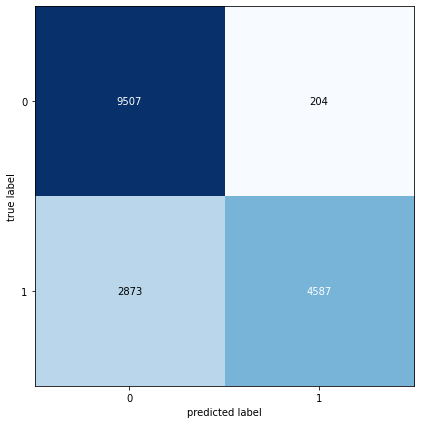

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Predicción del modelo usando los datos de prueba
y_pred = model_clf.predict(X_DoS_test)
matriz = confusion_matrix(Y_DoS_test,y_pred)

plot_confusion_matrix(conf_mat=matriz, figsize=(6,6), show_normed=False)
plt.tight_layout()


# Selección de características (luego de aplicar RF ver si es necesario lo siguiente)


## 1. Selección de características univariantes mediante la prueba F de ANOVA

In [ ]:
#Selección de características univariantes con prueba F de ANOVA (analisis de varianza). Usando el método secondPercentile, luego RFE
#Scikit-learn expone la selección de características como objetos que implementan el método de transformación

from sklearn.feature_selection import SelectPercentile, f_classif
# setter() establece cómo se manejan los errores de punto flotante.
np.seterr(divide='ignore', invalid='ignore');

# SelectPercentile(): selecciona las características según un percentil de las puntuaciones más altas. Elimina todos los rasgos excepto el porcentaje de puntuación más alto
# f_classif: Calcula el valor ANOVA F de la muestra proporcionada. Valor F de ANOVA entre etiqueta/característica para tareas de clasificación.
# Función que toma dos matrices X e y, y devuelve un par de matrices (puntuaciones, pvalores) o una única matriz con puntuaciones. 
# Los métodos basados en la prueba F estiman el grado de dependencia lineal entre dos variables aleatorias.
# percentile: El porcentaje de características que hay que mantener.

# Ajustar a los datos
selector=SelectPercentile(f_classif, percentile=10)

# Transformar los datos
X_newDoS = selector.fit_transform(X_DoS,Y_DoS)
X_newDoS.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 16  44  63  66  68  86 114] are constant.
  UserWarning)


(113270, 13)

### Obtener las características seleccionadas: DoS

In [ ]:
# get_support() permite obtener una máscara, o índice entero, de las características seleccionadas. En este caso se usa para realizar la iteracion
true=selector.get_support()
newcolindex_DoS=[i for i, x in enumerate(true) if x]
newcolname_DoS=list( colNames[i] for i in newcolindex_DoS )
newcolname_DoS

['logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'service_http',
 'flag_S0',
 'flag_SF']

In [ ]:
X_newProbe = selector.fit_transform(X_Probe,Y_Probe)
X_newProbe.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 16] are constant.
  UserWarning)


(78999, 13)

### Obtener las características que fueron seleccionadas: Probe

In [ ]:
true=selector.get_support()
newcolindex_Probe=[i for i, x in enumerate(true) if x]
newcolname_Probe=list( colNames[i] for i in newcolindex_Probe )
newcolname_Probe

['logged_in',
 'rerror_rate',
 'srv_rerror_rate',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'Protocol_type_icmp',
 'service_eco_i',
 'service_private',
 'flag_SF']

In [ ]:
X_newR2L = selector.fit_transform(X_R2L,Y_R2L)
X_newR2L.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  76  77  78  79  80  81  82  83  86  87  89  92
  93  96  98  99 100 107 108 109 110 114] are constant.
  UserWarning)


(68338, 13)

### Obtener las características que fueron seleccionadas: R2L

In [ ]:
true=selector.get_support()
newcolindex_R2L=[i for i, x in enumerate(true) if x]
newcolname_R2L=list( colNames[i] for i in newcolindex_R2L)
newcolname_R2L

['src_bytes',
 'dst_bytes',
 'hot',
 'num_failed_logins',
 'is_guest_login',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp',
 'service_ftp_data',
 'service_http',
 'service_imap4',
 'flag_RSTO']

In [ ]:
X_newU2R = selector.fit_transform(X_U2R,Y_U2R)
X_newU2R.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  75  76  77  78  79  80  81  82  83  86  87  89
  92  93  96  98  99 100 107 108 109 110 114] are constant.
  UserWarning)


(67395, 13)

### Obtener las características que fueron seleccionadas: U2R

In [ ]:
true=selector.get_support()
newcolindex_U2R=[i for i, x in enumerate(true) if x]
newcolname_U2R=list( colNames[i] for i in newcolindex_U2R)
newcolname_U2R

['urgent',
 'hot',
 'root_shell',
 'num_file_creations',
 'num_shells',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp_data',
 'service_http',
 'service_telnet']

# Resumen de las características seleccionadas por la selección de características univariantes

In [ ]:
print('Características seleccionadas para DoS:',newcolname_DoS)
print('\nCantidad de características seleccionadas para DoS:',len(newcolname_DoS))

print('\nCaracterísticas seleccionadas para: Probe',newcolname_Probe)
print('\nCantidad de características seleccionadas para Probe:',len(newcolname_Probe))

print('\nCaracterísticas seleccionadas para: R2L',newcolname_R2L)
print('\nCantidad de características seleccionadas para R2L:',len(newcolname_R2L))

print('\nCaracterísticas seleccionadas para: U2R',newcolname_U2R)
print('\nCantidad de características seleccionadas para U2R:',len(newcolname_U2R))

Características seleccionadas para DoS: ['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_http', 'flag_S0', 'flag_SF']

Cantidad de características seleccionadas para DoS: 13

Características seleccionadas para: Probe ['logged_in', 'rerror_rate', 'srv_rerror_rate', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_icmp', 'service_eco_i', 'service_private', 'flag_SF']

Cantidad de características seleccionadas para Probe: 13

Características seleccionadas para: R2L ['src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'is_guest_login', 'dst_host_srv_count', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp', 'service_ftp_data', 'service_http', 'service_imap4', 'flag_RSTO']

Cantidad de ca